In [1]:
import pandas as pd
uselog=pd.read_csv("use_log.csv")
uselog.isnull().sum()
customer=pd.read_csv("customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [2]:
customer_clustering=customer[["mean","median","max","min","membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
customer_clustering_sc=sc.fit_transform(customer_clustering)

kmeans=KMeans(n_clusters=4,random_state=0)
clusters=kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"]=clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[2 0 3 1]


<ipython-input-18-7c871d053fe5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"]=clusters.labels_


,월평균값,월중앙값,월최대값,월최소값,회원기간,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


In [19]:
customer_clustering.columns=["월평균값","월중앙값","월최대값","월최소값","회원기간","cluster"]
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최대값,월최소값,회원기간
cluster,,,,,
0,771,771,771,771,771
1,840,840,840,840,840
2,1249,1249,1249,1249,1249
3,1332,1332,1332,1332,1332


In [20]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최대값,월최소값,회원기간
cluster,,,,,
0,3.065504,2.900130,4.783398,1.649805,9.276265
1,8.061942,8.047024,10.014286,6.175000,7.019048
2,4.677561,4.670937,7.233787,2.153723,36.915933
3,5.539535,5.391141,8.756006,2.702703,14.867868


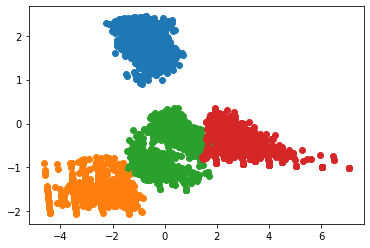

In [21]:
from sklearn.decomposition import PCA
X=customer_clustering_sc
pca=PCA(n_components=2)
pca.fit(X)
x_pca=pca.transform(X)
pca_df=pd.DataFrame(x_pca)
pca_df["cluster"]=customer_clustering["cluster"]

import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp=pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0],tmp[1])

In [22]:
customer_clustering=pd.concat([customer_clustering,customer],axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,1,771
1,1,0,821
2,1,1,19
3,2,0,1231
4,2,1,18
5,3,0,790
6,3,1,542


In [23]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,499
1,0,1,272
2,1,0,52
3,1,1,788
4,2,0,2
5,2,1,1247
6,3,0,226
7,3,1,1106


In [24]:
uselog["usedate"]=pd.to_datetime(uselog["usedate"])
uselog["연월"]=uselog["usedate"].dt.strftime("%Y%m")
uselog_months=uselog.groupby(["연월","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"},inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [27]:
year_months=list(uselog_months["연월"].unique())
predict_data=pd.DataFrame()
for i in range(6,len(year_months)):
    tmp=uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"},inplace=True)
    for j in range(1,7):
        tmp_before=uselog_months.loc[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)},inplace=True)
        tmp=pd.merge(tmp,tmp_before,on="customer_id",how="left")
    predict_data=pd.concat([predict_data,tmp],ignore_index=True)
predict_data.head()

C:\Users\Moribito\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [28]:
predict_data=predict_data.dropna()
predict_data=predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [29]:
predict_data=pd.merge(predict_data,customer[["customer_id","start_date"]],on="customer_id",how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
